<a href="https://colab.research.google.com/github/Cado87/RF-DETR-Play/blob/main/how-to-finetune-rf-detr-on-detection-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment setup

### Configure API Key

To fine-tune RF-DETR, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy` to copy your private API key.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store your Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Mon Dec 15 18:42:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install dependencies

Installs RF-DETR version 1.2.1 or higher (which includes the new Nano, Small, and Medium checkpoints), along with Supervision for benchmarking and Roboflow for pulling datasets and uploading models to the Roboflow platform.

In [3]:
!pip install -q rfdetr==1.2.1 supervision==0.26.1 roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 10.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 116.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.8/372.8 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Download Dataset from Roboflow Universe

RF-DETR expects the dataset to be in COCO format. Divide your dataset into three subdirectories: `train`, `valid`, and `test`. Each subdirectory should contain its own `_annotations.coco.json` file that holds the annotations for that particular split, along with the corresponding image files. Below is an example of the directory structure:

```
dataset/
├── train/
│   ├── _annotations.coco.json
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ... (other image files)
├── valid/
│   ├── _annotations.coco.json
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ... (other image files)
└── test/
    ├── _annotations.coco.json
    ├── image1.jpg
    ├── image2.jpg
    └── ... (other image files)
```

[Roboflow](https://roboflow.com/annotate) allows you to create object detection datasets from scratch or convert existing datasets from formats like YOLO, and then export them in COCO JSON format for training. You can also explore [Roboflow Universe](https://universe.roboflow.com/) to find pre-labeled datasets for a range of use cases.

In [ ]:
#Download dataset from Github
# !wget -q https://github.com/Cado87/Fruit-dataset/archive/refs/heads/main.zip -O fruit-dataset.zip
# !unzip -q fruit-dataset.zip -d /content/
# !rm fruit-dataset.zip

# print("Dataset downloaded and extracted to /content/Fruit-dataset/")

Dataset downloaded and extracted to /content/Fruit-dataset/


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Unzip folder from /content/drive/MyDrive/Datasets/Fruits/Fruit-dataset.zip
!unzip -q /content/drive/MyDrive/Datasets/Fruits/Fruit-dataset.zip -d /content/

In [8]:
from roboflow import download_dataset

# Define a simple class to mimic the dataset object structure
class MockDataset:
    def __init__(self, location):
        self.location = location

# Assign the fruit dataset location to the 'dataset' variable
dataset = MockDataset("/content/Dataset_2/")
print(f"Dataset location set to: {dataset.location}")

Dataset location set to: /content/Dataset_2/


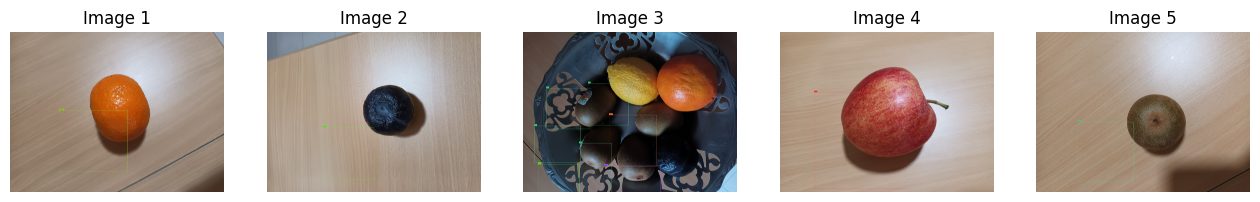

In [14]:
#Check dataset labels

import supervision as sv
from PIL import Image
import random

# Get class names from the full_dataset for display
class_names = full_dataset.classes

# Create annotators
bbox_annotator = sv.BoxAnnotator(color=sv.ColorPalette.DEFAULT, thickness=2)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.DEFAULT,
    text_color=sv.Color.BLACK,
    text_scale=0.5,
    text_thickness=1
)

# Select a few random images from the full dataset for visualization
num_images_to_display = 5
image_indices = random.sample(range(len(full_dataset)), min(num_images_to_display, len(full_dataset)))

annotated_images = []
for index in image_indices:
    path, image, annotations = full_dataset[index]
    image = Image.open(path).convert("RGB")

    labels = [
        f"{class_names[class_id]}"
        for class_id
        in annotations.class_id
    ]

    # Annotate the image with bounding boxes and labels
    annotated_image = bbox_annotator.annotate(image.copy(), annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, labels=labels)
    annotated_images.append(annotated_image)

# Display the annotated images
if annotated_images:
    sv.plot_images_grid(
        images=annotated_images,
        titles=[f"Image {i+1}" for i in range(len(annotated_images))],
        grid_size=(1, len(annotated_images)), # Display all in one row
        size=(16, 8)
    )
else:
    print("No images to display from the full dataset.")

In [9]:
import supervision as sv
import os

# The `dataset` variable from the previous cell `hQkMUyB0lROT` now holds the path.
# dataset.location is "/content/Fruit-dataset-main/"

# Load the entire dataset from the COCO format files
full_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=dataset.location,
    annotations_path=os.path.join(dataset.location, "_annotations.coco.json")
)

# Print total dataset size
print(f"Total images in dataset: {len(full_dataset)}")

# Split the dataset into train, validation, and test sets
# First, split into train and a remaining part (20%)
ds_train, ds_remaining = full_dataset.split(split_ratio=0.8, shuffle=True)
# Then, split the remaining part (20%) into validation (10%) and test (10%)
ds_valid, ds_test = ds_remaining.split(split_ratio=0.5, shuffle=True)

print(f"Train set size: {len(ds_train)} images")
print(f"Validation set size: {len(ds_valid)} images")
print(f"Test set size: {len(ds_test)} images")

# Export the datasets to COCO JSON format
def export_dataset_to_coco(dataset_obj, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    dataset_obj.as_coco(annotations_path=os.path.join(output_dir, "_annotations.coco.json"), images_directory_path=output_dir)
    print(f"Exported {len(dataset_obj)} images to {output_dir}")

# Create subdirectories for train, valid, and test within dataset.location
train_output_dir = os.path.join(dataset.location, "train")
valid_output_dir = os.path.join(dataset.location, "valid")
test_output_dir = os.path.join(dataset.location, "test")

# Export each split
export_dataset_to_coco(ds_train, train_output_dir)
export_dataset_to_coco(ds_valid, valid_output_dir)
export_dataset_to_coco(ds_test, test_output_dir)


Total images in dataset: 49
Train set size: 39 images
Validation set size: 5 images
Test set size: 5 images
Exported 39 images to /content/Dataset_2/train
Exported 5 images to /content/Dataset_2/valid
Exported 5 images to /content/Dataset_2/test


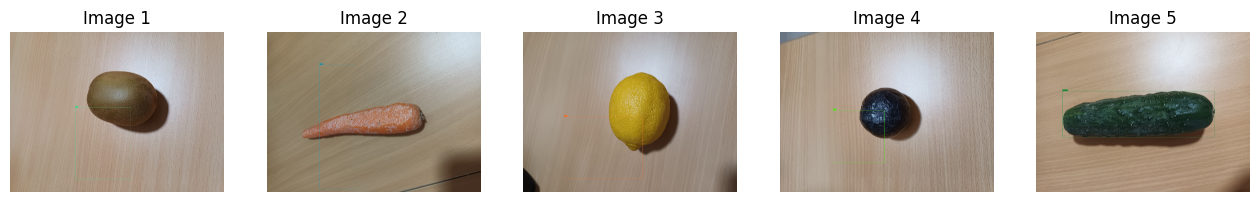

In [10]:
import supervision as sv
from PIL import Image
import random

# Get class names from the dataset for display
class_names = ds_train.classes

# Create annotators
bbox_annotator = sv.BoxAnnotator(color=sv.ColorPalette.DEFAULT, thickness=2)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.DEFAULT,
    text_color=sv.Color.BLACK,
    text_scale=0.5,
    text_thickness=1
)

# Select a few random images from the training set for visualization
num_images_to_display = 5
image_indices = random.sample(range(len(ds_train)), min(num_images_to_display, len(ds_train)))

annotated_images = []
for index in image_indices:
    path, image, annotations = ds_train[index]
    image = Image.open(path).convert("RGB")

    labels = [
        f"{class_names[class_id]}"
        for class_id
        in annotations.class_id
    ]

    # Annotate the image with bounding boxes and labels
    annotated_image = bbox_annotator.annotate(image.copy(), annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, labels=labels)
    annotated_images.append(annotated_image)

# Display the annotated images
if annotated_images:
    sv.plot_images_grid(
        images=annotated_images,
        titles=[f"Image {i+1}" for i in range(len(annotated_images))],
        grid_size=(1, len(annotated_images)), # Display all in one row
        size=(16, 8)
    )
else:
    print("No images to display from the training set.")

## Train RF-DETR on custom dataset

### Choose the right `batch_size`

Different GPUs have different amounts of VRAM (video memory), which limits how much data they can handle at once during training. To make training work well on any machine, you can adjust two settings: `batch_size` and `grad_accum_steps`. These control how many samples are processed at a time. The key is to keep their product equal to 16 — that’s our recommended total batch size. For example, on powerful GPUs like the A100, set `batch_size=16` and `grad_accum_steps=1`. On smaller GPUs like the T4, use `batch_size=4` and `grad_accum_steps=4`. We use a method called gradient accumulation, which lets the model simulate training with a larger batch size by gradually collecting updates before adjusting the weights.

In [ ]:
from rfdetr import RFDETRNano

model = RFDETRNano()

model.train(dataset_dir=dataset.location, epochs=30, batch_size=4, grad_accum_steps=4)

rf-detr-nano.pth: 100%|██████████| 349M/349M [00:05<00:00, 65.9MiB/s]


Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


reinitializing your detection head with 13 classes.


TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir output' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=13, grad_accum_steps=4, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=4, weight_decay=0.0001, epochs=30, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-nano.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[3, 6, 9, 12], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=2, dim_feedforward=2048, hidden_dim=256, sa_nheads=8, ca_nheads=

Epoch: [0]  [0/5]  eta: 0:01:27  lr: 0.000100  class_error: 76.92  loss: 10.0063 (10.0063)  loss_ce: 1.0274 (1.0274)  loss_bbox: 1.1122 (1.1122)  loss_giou: 0.7865 (0.7865)  loss_ce_0: 0.9214 (0.9214)  loss_bbox_0: 1.4373 (1.4373)  loss_giou_0: 0.9799 (0.9799)  loss_ce_enc: 0.7681 (0.7681)  loss_bbox_enc: 1.7467 (1.7467)  loss_giou_enc: 1.2269 (1.2269)  loss_ce_unscaled: 1.0274 (1.0274)  class_error_unscaled: 76.9231 (76.9231)  loss_bbox_unscaled: 0.2224 (0.2224)  loss_giou_unscaled: 0.3933 (0.3933)  cardinality_error_unscaled: 3619.7500 (3619.7500)  loss_ce_0_unscaled: 0.9214 (0.9214)  loss_bbox_0_unscaled: 0.2875 (0.2875)  loss_giou_0_unscaled: 0.4899 (0.4899)  cardinality_error_0_unscaled: 3533.5000 (3533.5000)  loss_ce_enc_unscaled: 0.7681 (0.7681)  loss_bbox_enc_unscaled: 0.3493 (0.3493)  loss_giou_enc_unscaled: 0.6134 (0.6134)  cardinality_error_enc_unscaled: 3548.7500 (3548.7500)  time: 17.5536  data: 4.9601  max mem: 2700
Epoch: [0]  [4/5]  eta: 0:00:06  lr: 0.000100  class_err

Test:  [0/2]  eta: 0:00:03  class_error: 75.00  loss: 5.5184 (5.5184)  loss_ce: 1.4297 (1.4297)  loss_bbox: 0.1319 (0.1319)  loss_giou: 0.1052 (0.1052)  loss_ce_0: 1.4219 (1.4219)  loss_bbox_0: 0.1279 (0.1279)  loss_giou_0: 0.1203 (0.1203)  loss_ce_enc: 1.2500 (1.2500)  loss_bbox_enc: 0.5276 (0.5276)  loss_giou_enc: 0.4039 (0.4039)  loss_ce_unscaled: 1.4297 (1.4297)  class_error_unscaled: 75.0000 (75.0000)  loss_bbox_unscaled: 0.0264 (0.0264)  loss_giou_unscaled: 0.0526 (0.0526)  cardinality_error_unscaled: 286.2500 (286.2500)  loss_ce_0_unscaled: 1.4219 (1.4219)  loss_bbox_0_unscaled: 0.0256 (0.0256)  loss_giou_0_unscaled: 0.0601 (0.0601)  cardinality_error_0_unscaled: 246.5000 (246.5000)  loss_ce_enc_unscaled: 1.2500 (1.2500)  loss_bbox_enc_unscaled: 0.1055 (0.1055)  loss_giou_enc_unscaled: 0.2020 (0.2020)  cardinality_error_enc_unscaled: 299.0000 (299.0000)  time: 1.6740  data: 1.4800  max mem: 2700
Test:  [1/2]  eta: 0:00:00  class_error: 0.00  loss: 5.5184 (7.2815)  loss_ce: 0.839

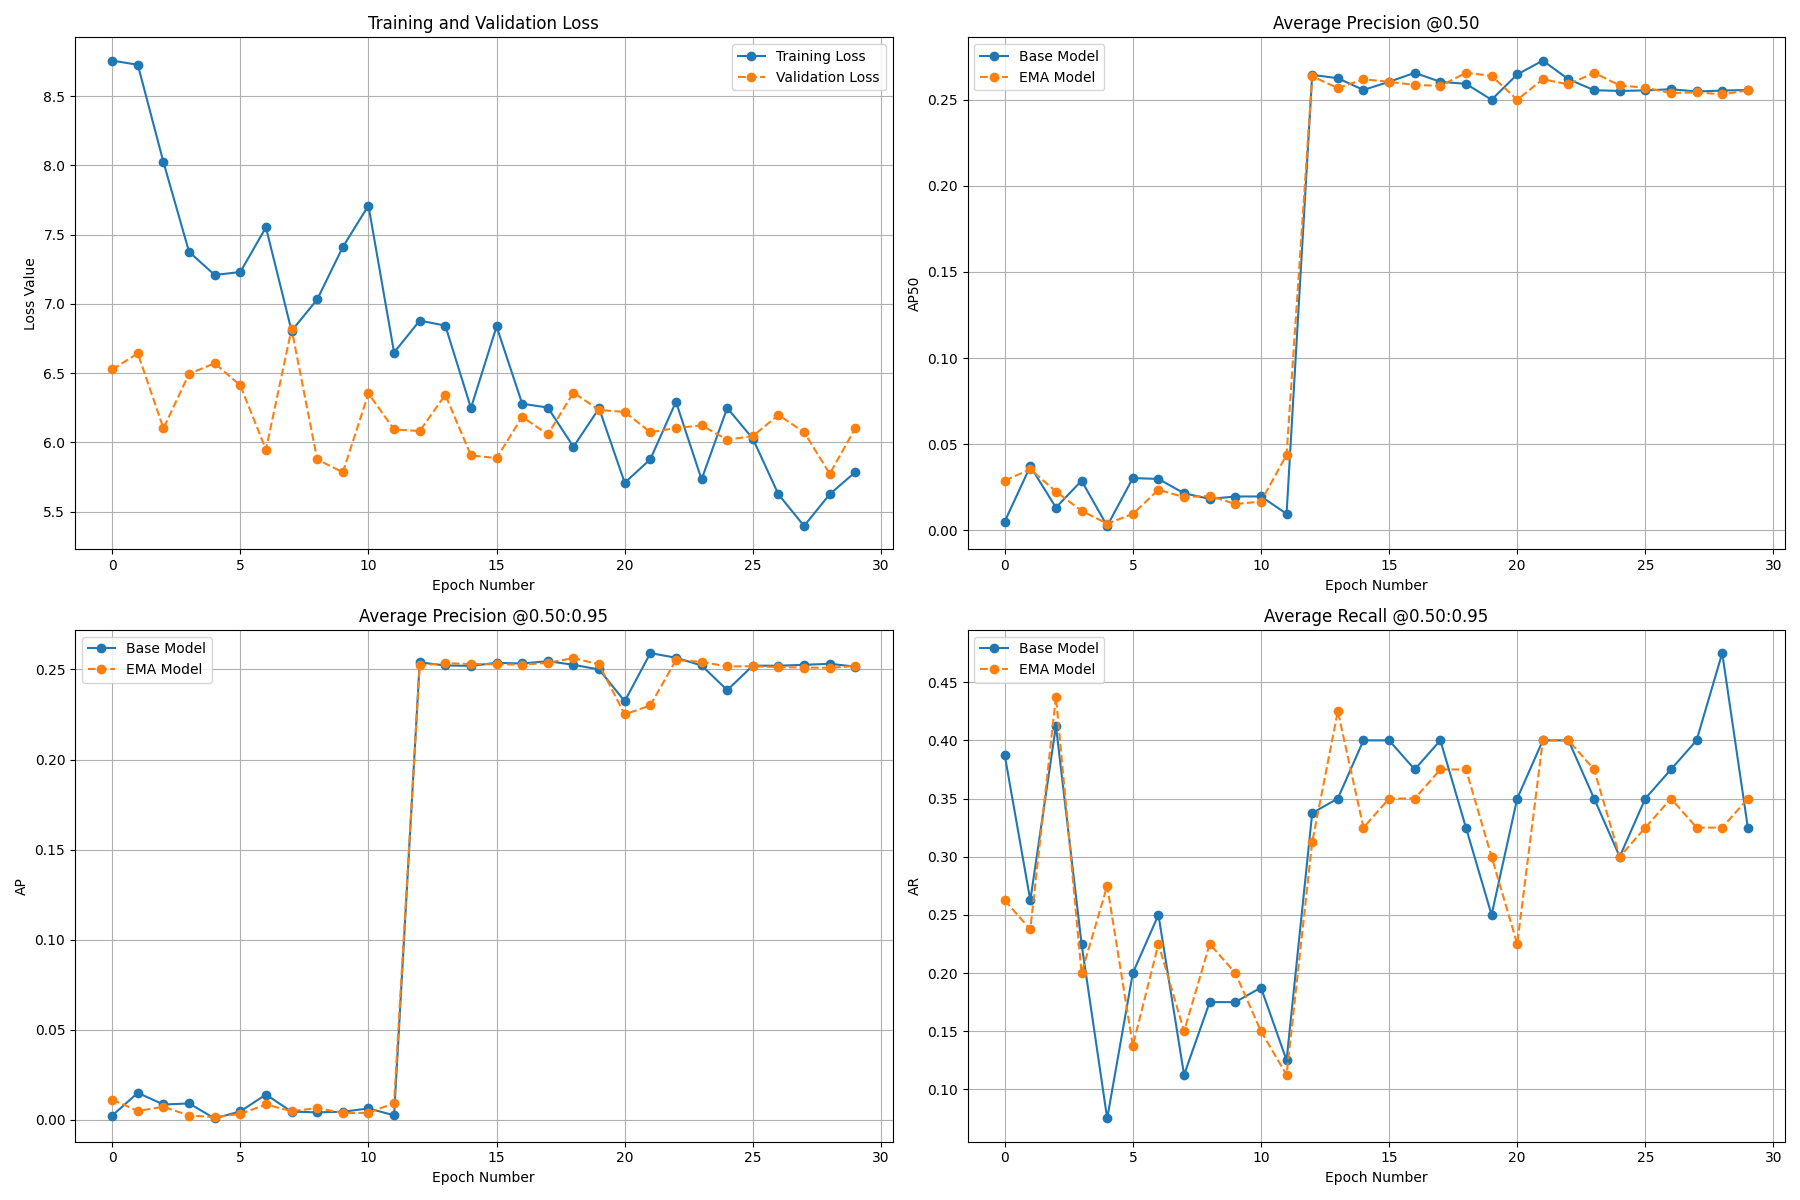

In [ ]:
from PIL import Image

Image.open("/content/output/metrics_plot.png")

In [ ]:
!ls -la /content/output

total 1771124
drwxr-xr-x 3 root root      4096 Dec  6 05:54 .
drwxr-xr-x 1 root root      4096 Dec  6 05:50 ..
-rw-r--r-- 1 root root 483556397 Dec  6 05:54 checkpoint0009.pth
-rw-r--r-- 1 root root 362696362 Dec  6 05:53 checkpoint_best_ema.pth
-rw-r--r-- 1 root root 362703878 Dec  6 05:54 checkpoint_best_regular.pth
-rw-r--r-- 1 root root 120868703 Dec  6 05:54 checkpoint_best_total.pth
-rw-r--r-- 1 root root 483547085 Dec  6 05:54 checkpoint.pth
drwxr-xr-x 2 root root      4096 Dec  6 05:51 eval
-rw-r--r-- 1 root root      4412 Dec  6 05:54 events.out.tfevents.1765000239.23a8ce427548.173.0
-rw-r--r-- 1 root root     51668 Dec  6 05:54 log.txt
-rw-r--r-- 1 root root    159921 Dec  6 05:54 metrics_plot.png
-rw-r--r-- 1 root root      1066 Dec  6 05:54 results.json


## Deploy a Trained RF-DETR Model

Deploying to Roboflow allows you to create multi-step computer vision applications that run both in the cloud and your own hardware. Please wait a moment while Roboflow indexes your model.

In [ ]:
model.deploy_to_roboflow(
  workspace="roboflow-jvuqo",
  project_id="basketball-player-detection-2",
  version=13,
  api_key=os.environ["ROBOFLOW_API_KEY"]
)

## Evaluate Fine-tuned RF-DETR Model

Before benchmarking the model, we need to load the best saved checkpoint. To ensure it fits on the GPU, we first need to free up GPU memory. This involves deleting any remaining references to previously used objects, triggering Python’s garbage collector, and clearing the CUDA memory cache.

In [ ]:
import gc
import torch
import weakref

def cleanup_gpu_memory(obj=None, verbose: bool = False):

    if not torch.cuda.is_available():
        if verbose:
            print("[INFO] CUDA is not available. No GPU cleanup needed.")
        return

    def get_memory_stats():
        allocated = torch.cuda.memory_allocated()
        reserved = torch.cuda.memory_reserved()
        return allocated, reserved

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[Before] Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

    # Ensure we drop all strong references
    if obj is not None:
        ref = weakref.ref(obj)
        del obj
        if ref() is not None and verbose:
            print("[WARNING] Object not fully garbage collected yet.")

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[After]  Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

In [ ]:
cleanup_gpu_memory(model, verbose=True)

We load the best-performing model from the `checkpoint_best_total.pth` file using the `RFDETRMedium` class. This checkpoint contains the trained weights from our most successful training run. After loading, we call `optimize_for_inference()`, which prepares the model for efficient inference.

In [ ]:
model = RFDETRNano(pretrain_weights="/content/output/checkpoint_best_total.pth")
model.optimize_for_inference()

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.


reinitializing detection head with 7 classes


Loading pretrain weights


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

In [ ]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0)

    targets.append(annotations)
    predictions.append(detections)

100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


In [ ]:
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()
print(map_result)

Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 1.000
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]                 = -1.000
Average Precision (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]                 = 1.000


## Run Inference with Fine-tuned RF-DETR Model

Number of detections: 1
Detections confidence scores: [0.92717105]


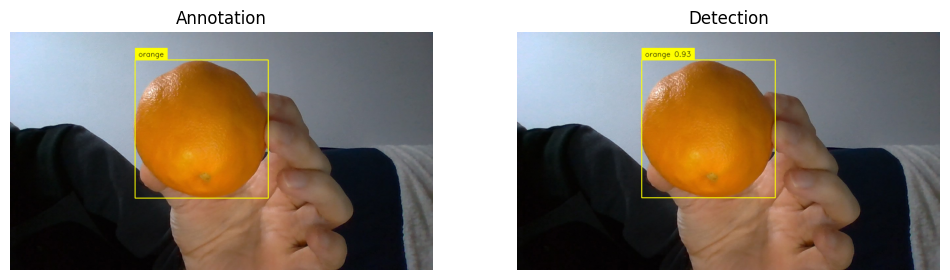

In [ ]:
import supervision as sv
from PIL import Image

path, image, annotations = ds[0]
image = Image.open(path)

detections = model.predict(image, threshold=0.8)

print(f"Number of detections: {len(detections)}")
if len(detections) > 0:
    print(f"Detections confidence scores: {detections.confidence}")

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
    "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

bbox_annotator = sv.BoxAnnotator(color=color,thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

det_labels = []
if len(detections) > 0:
    det_labels = [
        f"{ds.classes[class_id]} {confidence:.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, det_labels)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])

In [ ]:
!pip install -q inference-gpu==0.51.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 6.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.1/190.1 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from inference import get_model

MODEL_ID = "basketball-player-detection-2/13"
model_rf = get_model(model_id=MODEL_ID, api_key = userdata.get("ROBOFLOW_API_KEY"))

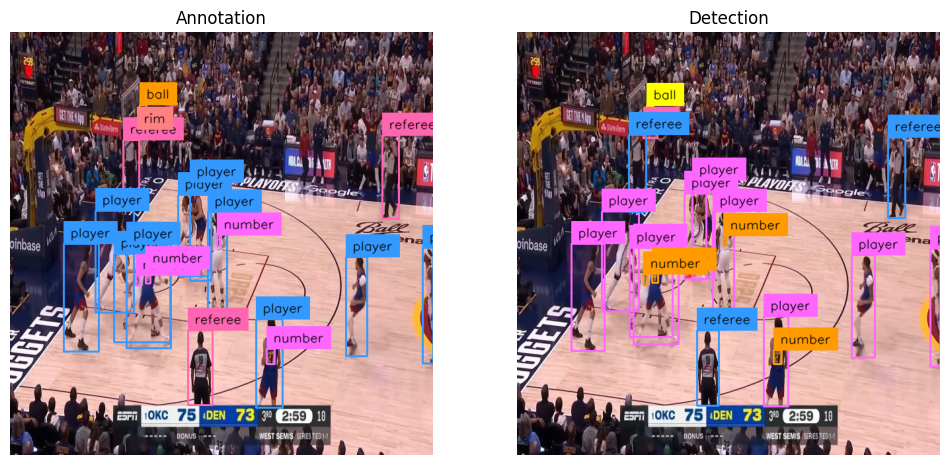

In [ ]:
import supervision as sv
from PIL import Image

path, image, annotations = ds[0]
image = Image.open(path)

result = model_rf.infer(image, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
    "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

bbox_annotator = sv.BoxAnnotator(color=color,thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])

<div align="center">
  <p>
    Looking for more tutorials or have questions?
    Check out our <a href="https://github.com/roboflow/notebooks">GitHub repo</a> for more notebooks,
    or visit our <a href="https://discord.gg/GbfgXGJ8Bk">discord</a>.
  </p>
  
  <p>
    <strong>If you found this helpful, please consider giving us a ⭐
    <a href="https://github.com/roboflow/notebooks">on GitHub</a>!</strong>
  </p>

</div>

# Task
Export the `ds_train`, `ds_valid`, and `ds_test` `DetectionDataset` objects to COCO JSON format, saving the files as `_annotations.coco.json` in the `train`, `valid`, and `test` subdirectories respectively, all located within `dataset.location`.

## Modify cell aSnuEzvfi1C5 to save COCO JSON files for train, valid, and test splits

### Subtask:
Export the `ds_train`, `ds_valid`, and `ds_test` `DetectionDataset` objects to COCO JSON format in their respective subdirectories within `dataset.location`.


## Summary:

### Data Analysis Key Findings
*   The `ds_train` dataset was successfully exported to a COCO JSON file named `_annotations.coco.json` within the `train` subdirectory of `dataset.location`.
*   The `ds_valid` dataset was successfully exported to a COCO JSON file named `_annotations.coco.json` within the `valid` subdirectory of `dataset.location`.
*   The `ds_test` dataset was successfully exported to a COCO JSON file named `_annotations.coco.json` within the `test` subdirectory of `dataset.location`.

### Insights or Next Steps
*   The exported COCO JSON files are now ready for use with various object detection model training frameworks that accept the COCO format, facilitating the next stage of model development.
*   These standardized annotation files provide a robust foundation for consistent dataset interpretation across different machine learning tools and pipelines.
